<h3>Research Question:</h3><p></p>

<p style="font-size: 24px">Data Cleaning</p>

In [28]:
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

#clean database on felonies and convert values to int
felonies_nyc= pd.read_csv("felony.csv")
for column in felonies_nyc.columns[1:]:
    if felonies_nyc[column].dtype != int:
        felonies_nyc[column] = felonies_nyc[column].str.replace(",", "").astype(int)

#clean database on non-felonies and convert values to int
nfelonies_nyc= pd.read_csv("non-felony.csv")
for column in nfelonies_nyc.columns[1:]:
    if nfelonies_nyc[column].dtype != int:
        nfelonies_nyc[column] = nfelonies_nyc[column].astype(int)

# Remove the last row from both, which contains individual daTa totals
felonies_nyc = felonies_nyc.iloc[:-1]
nfelonies_nyc = nfelonies_nyc.iloc[:-1]
merged_df = pd.concat([felonies_nyc, nfelonies_nyc], ignore_index=True)

#get totals starting from second column
new_totals = merged_df.iloc[1:].sum()

# Set the name for the last row in OFFENSE to Total Crime
merged_df.at[len(merged_df) - 1, 'OFFENSE'] = "Total Crime"

#add new totals to that row
merged_df.at[len(merged_df) - 1, 1:] = new_totals

print(merged_df)


                                      OFFENSE    2000    2001    2002    2003  \
0             MURDER & NON-NEGL. MANSLAUGHTER     673     649     587     597   
1                                        RAPE    2068    1981    2144    2070   
2                                     ROBBERY   32562   28202   27229   25989   
3                              FELONY ASSAULT   25924   23453   21147   19139   
4                                    BURGLARY   38352   32763   31275   29110   
5                               GRAND LARCENY   49631   46329   45771   46751   
6              GRAND LARCENY OF MOTOR VEHICLE   35442   29531   26656   23413   
7        FELONY POSSESSION OF STOLEN PROPERTY    2194    2114    1976    1545   
8          FORGERY/THEFT_FRAUD/IDENTITY THEFT    5714    5594    5859    8112   
9                                       ARSON    3189    2681    1902    1492   
10                      FELONY SEX CRIMES (3)    1839    1831    1513    1295   
11                 FELONY DA

c:\Users\anika\anaconda3\envs\Info2950\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


In [9]:
nyc_income= pd.read_csv('income.csv', encoding='latin1')


   Year      White  NonHispanic      Black      Asian      Mixed   Hispanic
0  1990  3827088.0    3163125.0  2102512.0   512719.0   880245.0  1783511.0
1  2000  3576385.0    2801267.0  2129762.0   792477.0  1509654.0  2160554.0
2  2010  3597341.0    2722904.0  2088510.0  1043535.0  1445747.0  2336076.0
3  2020  3000945.0    2719856.0  1943645.0  1385144.0  2474456.0  2490350.0
   Year         Race      Count
0  1990        White  3827088.0
1  2000        White  3576385.0
2  2010        White  3597341.0
3  2020        White  3000945.0
4  1990  NonHispanic  3163125.0


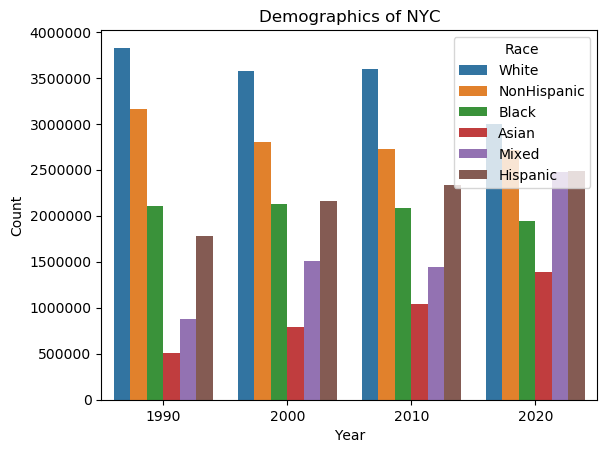

In [10]:
#reading in csv file
nyc_demographics= pd.read_csv('NYC_demographics.csv', encoding='latin1')

#changing year column values to int type so that they can be read as ints in further cleaning
nyc_demographics['Year']= nyc_demographics['Year'].astype(int)
#renaming column to prevent syntax issues 
nyc_demographics.rename(columns={'Non-Hispanic': 'NonHispanic'}, inplace=True)

#checking and changing column values that are originally objects and removing commas to facilitate float conversion later
for col in nyc_demographics:
    if nyc_demographics[col].dtype == 'object':
        nyc_demographics[col]= nyc_demographics[col].str.replace(",", "")

#changing the column value type from object to float
nyc_demographics[['White', 'NonHispanic', 'Black', 'Asian', 'Mixed',
                   'Hispanic',]]= nyc_demographics[['White', 'NonHispanic',
                    'Black', 'Asian', 'Mixed', 'Hispanic',]].astype(float)

#creating a clean dataframe that only has relevant columns
nyc_demographics_clean= db.sql("""
SELECT Year, White, NonHispanic, Black, Asian, Mixed, Hispanic
FROM nyc_demographics
WHERE Year > 1980""").df()
#confirming that new dataframe has correct information
print(nyc_demographics_clean)

#melting the dataframe and adding a column titled "Race" so that I can make a barplot that is colored by race
melted_demographic= pd.melt(nyc_demographics_clean, id_vars= 'Year', var_name= 'Race', value_name='Count')
print(melted_demographic.head())

#visualizing data with a barplot
sns.barplot(data= melted_demographic, x= 'Year', y='Count', hue='Race')
plt.title("Demographics of NYC")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Race", loc='upper right');

<p style="font-size: 20px;">Data Limitations</p>

<p>Some limitations we may approach when dealing with our data is the lack of dates (in years) for each dataset. For instance, we have crime data that spans from the year 2000 to 2020 and there are datapoints for every  year in between, meanwhile for demographic data we have usable data from the year 1990 to 2020, however there are only data points for each decade between that range. These limitations should not grossly affect any conclusions that we may come to make, but can possibly affect the intensity of our findings and the fit of our logistic regression model that we plan to produce in the future.</p>